In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nilearn.glm.first_level import glover_hrf
from scipy.stats import zscore
from nilearn import datasets
from nilearn.plotting import (plot_anat, plot_epi, plot_roi,
                              plot_glass_brain, plot_stat_map,
                              plot_surf_stat_map, plot_img_on_surf)
from nilearn.image import mean_img, resample_img
from nilearn.surface import vol_to_surf
from nilearn.masking import apply_mask
import nibabel as nib

main_path = "/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/"

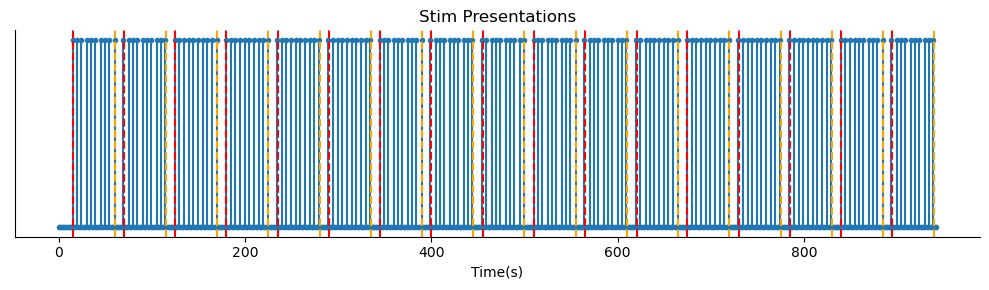

In [2]:
# load stimulus data
stim_df = pd.read_csv(os.path.join(main_path, 'stimulus_record/780929_502b_project_code_edited_2023-04-05_13h44.30.136.csv'))
t_scan_start = stim_df['key_resp.started'][0] + stim_df['key_resp.rt'][0]
stim_df.Language = stim_df.Language.str.split('_', expand=True).to_numpy()
stim_df.stimFile = stim_df.stimFile.str.split('/|_', expand=True).to_numpy()
stim_df.StimFile = stim_df.StimFile.str.split('/|_', expand=True).to_numpy()
stim_df['word'] = stim_df.stimFile

stim_df.loc[stim_df.word.isnull(), 'word'] = stim_df.loc[stim_df.word.isnull(), 'StimFile']
stim_df = stim_df[~stim_df.word.isnull()].reset_index(drop=True)

tr = 1.5
n_trs = 630
time = np.arange(0, n_trs*tr, tr)
stim_trs, _ = np.histogram(stim_df['Sound.started']-t_scan_start, bins=time)  # stims binned into TRs (have not adjusted for if they are presented right at the end of a TR)


## Detecting start and end time
stim_start = stim_df['Sound.started'].to_numpy() - t_scan_start
block_start_indices = np.where(np.diff(stim_start) > 5.5)[0]
## Total switches: (3 session * 6 languages) - 1 = 17
assert len(block_start_indices) == 17 

block_end_time = stim_start[block_start_indices]
iti_interval = stim_start[block_start_indices + 1] - stim_start[block_start_indices]
block_start_time = (block_end_time + iti_interval)[:-1]
## Insert first stim start at the beginning
block_start_time = np.insert(block_start_time, 0, stim_start[0])
duration = block_end_time - block_start_time

fig, ax = plt.subplots(figsize=(10, 3))
ax.stem(time[:-1], stim_trs, markerfmt='.', basefmt='C0')

for start, end in zip(block_start_time, block_end_time):
    ax.axvline(start, color='red', linestyle='--')
    ax.axvline(end, color='orange', linestyle='--')
ax.set_xlabel('Time(s)')
ax.set_title('Stim Presentations')
ax.set_yticks([])
plt.tight_layout()
sns.despine()

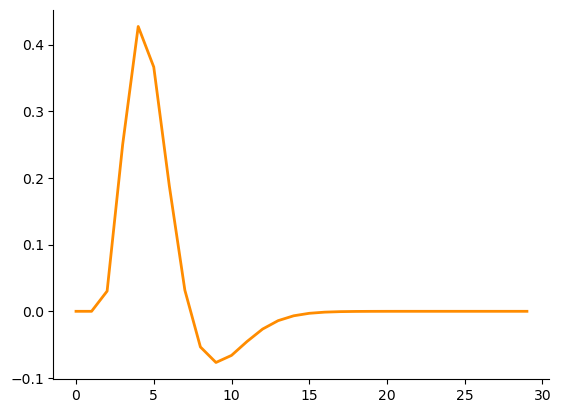

In [3]:
hrf = glover_hrf(tr, time_length = 45, oversampling = 1)
plt.plot(hrf, c='darkorange', lw = 2)
sns.despine()

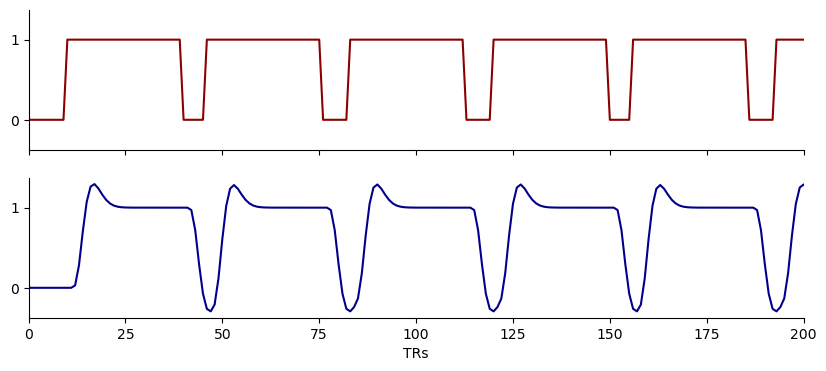

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex = True, sharey = True)

stim_arr = np.zeros(n_trs)
for start, end in zip(block_start_time, block_end_time):
    stim_arr[int(start / tr): int(end / tr)] = 1

stim_conv = np.convolve(stim_arr, hrf)[:n_trs]

axs[0].plot(stim_arr, c = "darkred")
axs[0].set_yticks([0, 1])
axs[0].set_xlim(0, 200)

axs[1].plot(stim_conv, c = "darkblue")
axs[1].set_xlabel("TRs")
sns.despine()

In [5]:
## Importing confounds
data_path = os.path.join(main_path, "data/bids/")
confounds_f = os.path.join(data_path, 'derivatives/fmriprep/sub-002/ses-01/func/sub-002_ses-01_task-language_desc-confounds_timeseries.tsv')
confounds_df = pd.read_table(confounds_f, sep='\t')

### Head motion error

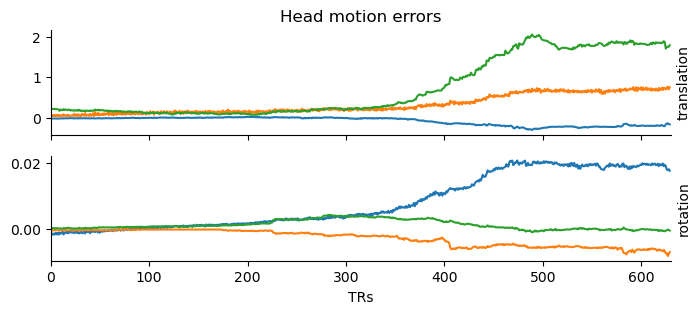

In [6]:
hm_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
hm = confounds_df[hm_labels].values

# Plot head motion parameters
fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharex=True)

axs[0].set_title("Head motion errors")
axs[0].plot(hm[:, :3])
axs[0].set_ylabel('translation')
axs[0].yaxis.set_label_position("right")
axs[1].plot(hm[:, 3:])
axs[1].set(xlabel='TRs', ylabel='rotation', xlim=(0, hm.shape[0]))
axs[1].yaxis.set_label_position("right")
sns.despine()

### Component based noise correction method (CompCor)

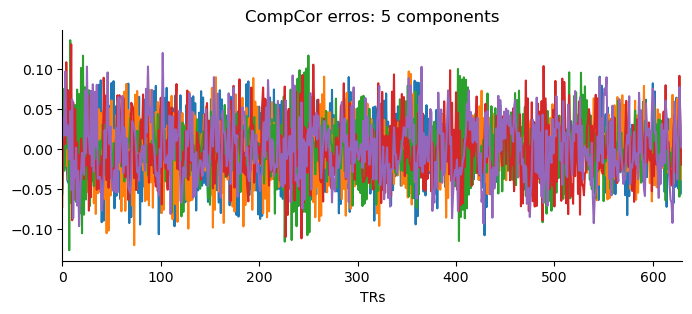

In [7]:
# Extract aCompCor signals from confounds table
acompcor_n = 5
acompcor_df = confounds_df.filter(regex='a_comp_cor').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values
acompcor = acompcor[: n_trs,:]

# Plot aCompCor regressors:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title(f"CompCor erros: {acompcor_n} components")
ax.plot(np.arange(n_trs), acompcor)
ax.set(xlim=(0, n_trs), xlabel='TRs')
sns.despine()

### Loading in BOLD data

In [8]:
func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
anat_path = os.path.join(data_path, 'sub-002/ses-01/anat/sub-002_ses-01_T1w.nii.gz')

func_data = nib.load(func_path).get_fdata()
mask = nib.load(anat_path).get_fdata().astype(bool)

(91, 109, 91)


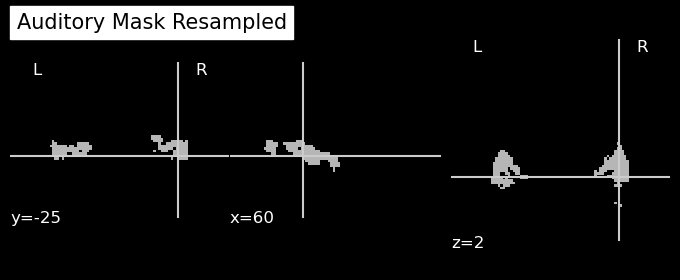

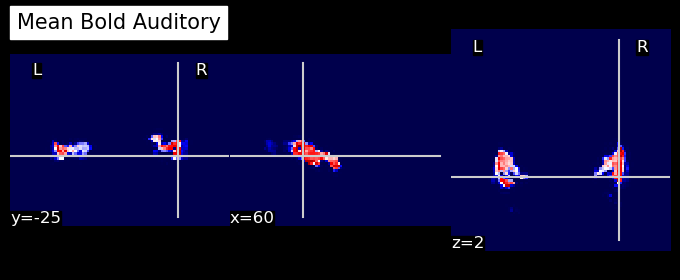

In [9]:
# get auditory mask
# source of auditory mask: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI
# left hemisphere aud is 137-146 inclusive. right hem is 336-344. if you change the parcel file, you will need to go the the 
aud = np.hstack((np.arange(137, 147), np.arange(336, 345)))
masker_path = 'Schaefer2018_400Parcels_Kong2022_17Networks_order_FSLMNI152_2mm.nii.gz'
cut_coords = (60, -25, 2)
aud_masker = nib.load(masker_path)
aud_masker_data = aud_masker.get_fdata()
print(aud_masker_data.shape)
aud_masker_data = np.where(np.isin(aud_masker_data, aud), 1., 0)
aud_masker_img = nib.Nifti1Image(aud_masker_data, affine=aud_masker.affine)

# resample mask to match functional data
func_img = nib.load(func_path)
masker = resample_img(aud_masker_img, func_img.affine, target_shape=func_data.shape[:3], interpolation='nearest')
mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)
plot_anat(masker, cut_coords=cut_coords, title='Auditory Mask Resampled');
plot_epi(mean_img(mask_aud), cut_coords=cut_coords, cmap='seismic', title='Mean Bold Auditory');

In [10]:
bold_masked = func_data[masker.get_fdata().astype(bool)].T
print('masked data shape:', bold_masked.shape)

masked data shape: (630, 2913)


9 bad volumes


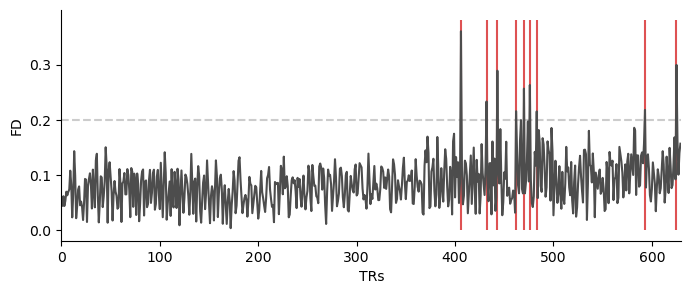

In [11]:
# Define FD threshold
fd_threshold = 0.2

# Extract framewise displacement
fd = confounds_df['framewise_displacement'].values

# Identify bad volumes
bad_vols = np.argwhere(fd > fd_threshold).ravel()
n_bad = bad_vols.shape[0]
print(f'{n_bad} bad volumes')

# Construct scrubbers
censors = np.zeros((fd.shape[0], n_bad))
censors[bad_vols, np.arange(n_bad)] = 1

# Plot the FD
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(fd, c='.3')
ax.hlines(fd_threshold, 0, fd.shape[0], colors='.8',
          linestyle='--', zorder=-1)
ax.vlines(bad_vols, 0, np.nanmax(fd) + .02, colors='tab:red',
          zorder=0, alpha=.8)
ax.set(xlim=(0, fd.size), xlabel='TRs', ylabel='FD')
sns.despine()

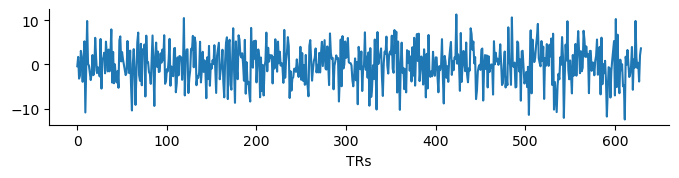

In [12]:
from nilearn.signal import clean
high_pass = 1/128

confounds = np.column_stack((hm, censors, acompcor))

# Re-run confound regression with high-pass filter
bold_clean = clean(bold_masked, 
                   confounds=confounds, 
                   detrend=True,
                   high_pass=high_pass, 
                   standardize='psc', 
                   t_r=tr)

# Plot an arbitrary voxel time series
voxel = 100
fig, ax = plt.subplots(figsize=(8, 1.5))
ax.plot(bold_clean[:, voxel])
ax.set_xlabel('TRs')
sns.despine()

In [13]:
data_dict = {
    "stim": stim_conv, 
    "BOLD": bold_clean,
}

In [21]:
np.save(os.path.join(main_path, 'preprocessed_data/bold_clean.npy'), 
        data_dict, allow_pickle=True)